In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage import io
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [57]:

# define the path to the input images
input_path = r"C:\Users\user\Documents\GitHub\Hand Gesture\Hand-Gesture\input"

# define the path to the output preprocessed images
output_path = r"C:\Users\user\Documents\GitHub\Hand Gesture\Hand-Gesture\output"

# define the target size of the preprocessed images
target_size = (64, 64)

# define the preprocessing functions


def convert_to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    return gray


def apply_gaussian_blur(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    return blurred


def apply_threshold(img):
    _, thresh = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh


def find_contours(img):
    contours, hierarchy = cv2.findContours(
        img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy


def find_largest_contour(contours):
    max_contour = max(contours, key=cv2.contourArea)
    return max_contour


def create_mask(img, contour):
    mask = cv2.drawContours(np.zeros_like(
        img), [contour], 0, (255, 255, 255), -1)
    return mask


def apply_mask(img, mask):
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    return masked_image


def resize_image(img, size):
    resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return resized


def normalize_image(img):
    normalized = img.astype("float32") / 255.0
    return normalized


def get_hog_features(img):
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(win_size, block_size,
                            block_stride, cell_size, nbins)
    hog_feats = hog.compute(img)
    return hog_feats


def get_sift_features(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def svm_model(X_train, y_train, X_test):
    clf = svm.SVC(kernel='rbf', C=100, gamma=0.5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
   
    # filename = 'SVC.sav'
    # pickle.dump(clf, open(filename, 'wb'))
    
    return y_pred

def knn_model(X_train, y_train, X_test):
    # Create the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=11)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = knn.predict(X_test)
    
    return y_pred


def random_forest_model(X_train, y_train, X_test):
    rfc = RandomForestClassifier(max_depth= None, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    
    # filename = 'RFC.sav'
    # pickle.dump(clf, open(filename, 'wb'))
    
    return y_pred


def calc_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [13]:
#preprocessing phase        
def preprocess(img_path):
    img = io.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = apply_gaussian_blur(gray)
    # blurred = np.uint8(blurred)
    thresh = apply_threshold(blurred)
    # contours, hierarchy = find_contours(thresh)
    # max_contour = find_largest_contour(contours)
    # mask = create_mask(gray, thresh)
    # masked_image = apply_mask(img, mask)
    resized = resize_image(thresh, target_size)
    normalized = normalize_image(resized)
    
    return normalized

def preprocess_3(img_path):
    img = io.imread(img_path)

    #1 Image Rescaling
    img = cv2.resize(img, (320, 200))

    #2 Image Enhancement
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gamma = 2

    # Calculate the lookup table
    lookup_table = np.zeros((256, 1), dtype='uint8')
    for i in range(256):
        lookup_table[i][0] = 255 * pow(float(i) / 255, 1.0 / gamma)

    # Apply the lookup table
    img_gray = cv2.LUT(img_gray, lookup_table)

    img_gray = cv2.equalizeHist(img_gray)

    #3 Background Subtraction
    fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=30)
    fgmask = fgbg.apply(img_gray)
    img_gray = cv2.bitwise_and(img_gray, img_gray, mask=fgmask)


    # #4 Noise Reduction
    # Blur
    img_gray = cv2.medianBlur(img_gray, 3)

    return img_gray

# preprocessed = preprocess_3('dataset/0/357.jpg')
# cv2.imwrite('output/'+'0'+'/'+'357.jpg', processed)
# io.imshow(preprocessed)
# cv2.imshow('Processed Image', preprocessed)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [14]:
# set the parameters for SIFT
nfeatures = 200
nOctaveLayers = 3
contrastThreshold = 0.04
edgeThreshold = 10
sigma = 1.6

sift = cv2.SIFT_create(
    nfeatures=nfeatures,
    nOctaveLayers=nOctaveLayers,
    contrastThreshold=contrastThreshold,
    edgeThreshold=edgeThreshold,
    sigma=sigma
)

In [15]:
def calc_final_pred(X, T, pred_list, alpha):
    n = X.shape[0]
    pred_final = np.zeros(n)
    for i in range(n):
        c_score = [0, 0, 0, 0, 0, 0]
        for j in range(T):
            pred = pred_list[j][i]
            if pred == 0:
                c_score[0] += alpha[j]
            elif pred == 1:
                c_score[1] += alpha[j]
            elif pred == 2:
                c_score[2] += alpha[j]
            elif pred == 3:
                c_score[3] += alpha[j]
            elif pred == 4:
                c_score[4] += alpha[j]
            elif pred == 5:
                c_score[5] += alpha[j]

        pred_final[i] = np.argmax(c_score)
    print(pred_final.max())
    print(pred_final.shape)
    return pred_final

def adaboost_classifier(Y_train, X_train, Y_test, X_test, T, clf):
    
    #TODO: FILL THE FUNCTION with the implementation as the steps above
    
    alpha = np.zeros(T)
    n = X_train.shape[0]
    m = X_test.shape[0]
    w_init = 1 / n
    # TODO [1]: Initialize weights
    w = [w_init for i in range(n)]

    ## TODO [2]:  Initialize the training and test data with empty array placeholders
    #### Hint: what should be their shape?
    pred_train = np.zeros((T, n)) ## predicted classes of the training examples
    pred_test = np.zeros((T, m))  ## predicted classes of the test examples

    ## TODO [3]: loop over the boosting iterations 
    for i in range(T): 
        print(i)
        # TODO [4]: Fit a classifier with the specific weights 
        ## TODO [4.A]: fit the classifier on the training data
        #### Hint: search how sklearn.tree.DecisionTreeClassifier fits classifier on data
        ### Hint: search for parameter weights in the fit matrix
        clf.fit(X_train, Y_train, sample_weight=w)
        
        # TODO [4.B]: predict classes for the training data and test data
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # TODO [5]: calculate the miss Indicator function
        miss_indecator = (pred_train_i != Y_train)
        
        # TODO [6]: calculate the error for the current classifier (err_t)
        err_t = np.sum(w * miss_indecator) / np.sum(w)
        
        # TODO [7]: calculate current classifier weight (Alpha_t)
        alpha_t = np.log((1-err_t) / err_t)
        alpha[i] = alpha_t
        
        # TODO [8]: update the weights 
        w *= np.exp(alpha_t * miss_indecator)
        
        # TODO [9] Add to the overall predictions
        pred_train[i] = pred_train_i
        pred_test[i] = pred_test_i
            
    pred_train_final = calc_final_pred(X_train, T, pred_train, alpha)
    pred_test_final = calc_final_pred(X_test, T, pred_test, alpha)
    
    # TODO [10]: Return error rate in train and test set
    #### Hint: use function get_accuracy from utils.py
#     train_error = get_accuracy(pred_train_final, Y_train)
#     test_error = get_accuracy(pred_test_final, Y_test)
    return pred_test_final

In [60]:
# Create the SIFT object
sift = cv2.SIFT_create()

# set the parameters for HoG
orientations = 9
pixels_per_cell = (50, 50)
cells_per_block = (3, 3)
visualize = False
transform_sqrt = False
normalize = True
load_features_from_file=False
save_feature=False
all_feats = []
all_imgs = []

image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

if load_features_from_file == False:
    for root, dirs, files in os.walk('dataset'):
        j = 0
        for dir in dirs:
            j+=1
            i = 0
            print(os.path.join(root, dir))
            for file in os.listdir(os.path.join(root, dir)):
                i+=1
                if file.startswith('none-'):
                    print(file)
                    continue
                if any(file.lower().endswith(extension) for extension in image_extensions):
                    img_path = os.path.join(root, dir, file)
                    # print(j, ' ', i)
                    # print(img_path)
                    label = np.array([int(dir)])
                    
                    processed = preprocess_3(img_path)
                    cv2.imwrite('output/'+dir+'/'+file, processed)
                    # processed = io.imread(img_path, as_gray=True)
                    # print(processed.shape)

                    #calculate the HoG features for the image
                    hog_result = hog(
                        processed,
                        orientations = orientations,
                        pixels_per_cell = pixels_per_cell,
                        cells_per_block = cells_per_block,
                        visualize = visualize,
                        transform_sqrt = transform_sqrt,
                        block_norm = 'L2-Hys',
                        feature_vector = True
                    )

                    # unpack the HoG result into features and hog_image variables if necessary
                    if visualize:
                        features, hog_image = hog_result
                    else:
                        features = hog_result

                    # Detect keypoints and compute descriptors
                    # kp, des = sift.detectAndCompute(preprocessed, None)
                    # print(des.shape)
                    # print(features.shape)
                    feats = np.concatenate((label, features.ravel()))
                    all_feats.append(feats)
           
else:
    all_feats = np.loadtxt("hog_features.txt")

features_array = np.array(all_feats, dtype=object)

if(save_feature):
    np.savetxt("hog_features.txt", features_array)


print("Feature Extraction Finished")

dataset/5
dataset/3
dataset/0
dataset/4
none-1561.jpg
none-1518.jpg
none-1506.jpg
none-685.jpg
none-656.jpg
none-622.jpg
none-619.jpg
none-614.jpg
dataset/1
dataset/2
Feature Extraction Finished


In [61]:
print(features_array.shape)

(1813, 649)


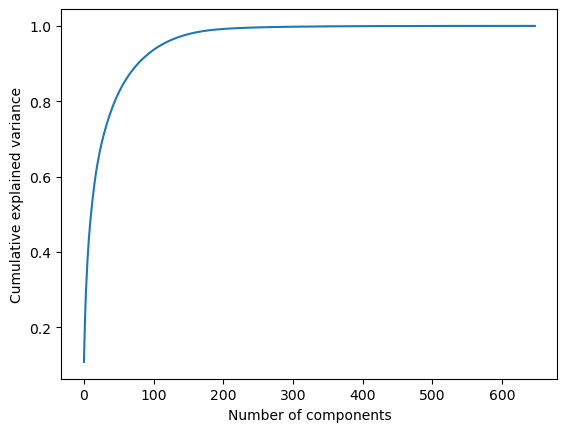

In [62]:
# get the optimal number of components to use

pca = PCA().fit(features_array[:, 1:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [126]:
# apply PCA
pca = PCA(n_components=120)
Y = np.array(features_array[:, 0]).astype('int32')
X = pca.fit_transform(features_array[:, 1:])

In [127]:
#timer starts
start_time = time.time()

# splitting data into train and test
X_train, X_test, y_train, y_test = split_dataset(X, Y)

####Trial 1
# apply SVM : acc:75 --> time:0.5 sec
y_pred = svm_model(X_train, y_train, X_test)


# y_pred = knn_model(X_train, y_train, X_test)

# apply RFC
# y_pred = random_forest_model(X_train, y_train, X_test)

#timer ended
end_time = time.time()

print("SVM Finished")

SVM Finished


In [128]:
print("Total Misclassifications: ", (y_test[np.where(y_pred != y_test)]).shape[0])

print("0: ", np.count_nonzero(y_test[np.where(y_pred != y_test)] == 0))
print("1: ", np.count_nonzero(y_test[np.where(y_pred != y_test)] == 1))
print("2: ", np.count_nonzero(y_test[np.where(y_pred != y_test)] == 2))
print("3: ", np.count_nonzero(y_test[np.where(y_pred != y_test)] == 3))
print("4: ", np.count_nonzero(y_test[np.where(y_pred != y_test)] == 4))
print("5: ", np.count_nonzero(y_test[np.where(y_pred != y_test)] == 5))

# calc accuracy
accuracy = calc_accuracy(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Running Time of classifier:", end_time - start_time, "seconds")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-score: {:.2f}%".format(f1 * 100))

Total Misclassifications:  54
0:  4
1:  2
2:  12
3:  22
4:  9
5:  5
Running Time of classifier: 0.533921480178833 seconds
Accuracy: 85.12%
Precision: 85.86%
Recall: 85.60%
F1-score: 85.58%


In [ ]:
# Grid Search
C_range=[0.01, 0.1, 1, 10, 100, 1000]
gamma_range=[1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5]
parameters= [
    {
        'kernel': ['rbf'],
        'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
        'C': [0.01, 0.1, 1, 10, 100, 1000]
    }, 
    {
       'kernel': ['linear'],
       'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
    }, 
    {
       'kernel': ['sigmoid'],
       'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
       'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
    }, 
    {
       'kernel': ['poly'],
       'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
       'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
    
]

clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), param_grid=parameters, cv=5)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print("Best parameters:", clf.best_params_)

In [ ]:
###Trial 2
# apply adaboost : n_estimator: 1000 -->acc:41% , 3000 -->acc:46% time:197 sec
ada = AdaBoostClassifier(n_estimators=3000, random_state=0)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

In [ ]:
###Trial 3
Define the range of values for n_estimators and random_state
param_grid = {
    'n_estimators': [10, 50, 100, 200,1000,2000],
    'random_state': [0, 1, 2, 3]
}

# create a Random Forest Classifier object :no parameters-->acc:62 time:4 sec, n=100-->acc:62 time:4 sec, n=1000 -->acc:67% time:41 sec
#Best parameters:  {'n_estimators': 200, 'random_state': 0} according to grid search method
rfc = RandomForestClassifier()
# Create a grid search object
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5)
# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)
# Print the best hyperparameters
print("Best parameters: ", grid_search.best_params_)
# Make predictions on the test data using the best model
y_pred = grid_search.predict(X_test)

#RF PART 2: if grid search gives the best tuned parameters apply it to the initializer then uncomment this. 
# # train the classifier on the training set
rfc.fit(X_train, y_train)
# # make predictions on the testing set
y_pred = rfc.predict(X_test)

In [50]:
# test for one image

# Load the image
image = cv2.imread('dataset/3/261.jpg')

# # Convert the image to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Apply Gaussian blur to reduce noise
# blur = cv2.GaussianBlur(gray, (5, 5), 0)

# # Apply thresholding to create a binary image
# _, threshold = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV)

# # Find contours in the binary image
# contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Filter contours based on area and shape
# print(contour)
# filtered_contours = []
# for contour in contours:
#     area = cv2.contourArea(contour)
#     if area > 1000:
#         epsilon = 0.04 * cv2.arcLength(contour, True)
#         approx = cv2.approxPolyDP(contour, epsilon, True)
#         if len(approx) == 4:
#             filtered_contours.append(contour)

# # Draw contours on the original image
# cv2.drawContours(image, filtered_contours, -1, (0, 255, 0), 2)

# # Display the result
# cv2.imshow('Hand Fingers', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # Convert the image to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Apply Gaussian blur to reduce noise
# blur = cv2.GaussianBlur(gray, (5, 5), 0)

# # Apply thresholding to create a binary image
# _, threshold = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV)

# # Find contours in the binary image
# contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Find the contour with the maximum area
# max_contour = max(contours, key=cv2.contourArea)

# # Create a convex hull around the contour
# hull = cv2.convexHull(max_contour, returnPoints=False)

# # Find convexity defects in the hull
# defects = cv2.convexityDefects(max_contour, hull)

# # Initialize a finger count
# finger_count = 0

# # Count the number of defects that match finger-like shapes
# if defects is not None:
#     for i in range(defects.shape[0]):
#         s, e, f, d = defects[i, 0]
#         start = tuple(max_contour[s][0])
#         end = tuple(max_contour[e][0])
#         far = tuple(max_contour[f][0])
#         angle = np.degrees(np.arctan2(far[1] - start[1], far[0] - start[0]))
#         if angle < 0:
#             angle += 180
#         if angle > 10 and angle < 100 and d > 10000:
#             cv2.circle(image, far, 3, (0, 255, 0), -1)
#             finger_count += 1

# # Display the result
# cv2.putText(image, str(finger_count), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
# cv2.imshow('Finger Count', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# cv2.imshow('Gray', gray)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Apply Gaussian blur to reduce noise
blur = cv2.GaussianBlur(gray, (7, 7), 0)

# cv2.imshow('Blur', blur)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Apply thresholding to create a binary image
_, threshold = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)

cv2.imshow('Threshold', threshold)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Find contours in the binary image
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the maximum area
max_contour = max(contours, key=cv2.contourArea)

# Create a convex hull around the contour
hull = cv2.convexHull(max_contour, returnPoints=False)

# Find convexity defects in the hull
defects = cv2.convexityDefects(max_contour, hull)

# Calculate the contour area
contour_area = cv2.contourArea(max_contour)

# Initialize feature variables
finger_count = 0
finger_lengths = []
finger_widths = []
finger_angles = []
print(defects)
# Count the number of defects that match finger-like shapes and extract features
if defects is not None:
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        start = tuple(max_contour[s][0])
        end = tuple(max_contour[e][0])
        far = tuple(max_contour[f][0])
        angle = np.degrees(np.arctan2(far[1] - start[1], far[0] - start[0]))
        if angle < 0:
            angle += 180
        if angle > 10 and angle < 100 and d > 10000:
            cv2.circle(image, far, 3, (0, 255, 0), -1)
            finger_count += 1
            finger_lengths.append(np.linalg.norm(start - end))
            finger_widths.append(d)
            finger_angles.append(angle)

# Print the extracted features
print("Finger Count:", finger_count)
print("Finger Lengths:", finger_lengths)
print("Finger Widths:", finger_widths)
print("Finger Angles:", finger_angles)

# Display the result
cv2.imshow('Finger Count', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[[   0   88   73 5176]]

 [[  88  243  218 4145]]

 [[ 244  259  253 2423]]

 [[ 261  263  262  186]]

 [[ 264  268  265  222]]

 [[ 268  270  269  217]]

 [[ 270  366  321 2119]]

 [[ 366  372  367  186]]

 [[ 372  392  387  585]]]
Finger Count: 0
Finger Lengths: []
Finger Widths: []
Finger Angles: []
